# Compare fits to UTUR GPS

Check UTUR timeseries for 3 models (simple linear regression, MIDAS, OSU)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize 
import pandas as pd

# Set enivronment variable python
import os
import gpstools as gps

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2
plt.rcParams['font.size'] = 14

In [3]:
# Update files from UNGL (http://geodesy.unr.edu/PlugNPlayPortal.php)
gps.auxfiles.ungl.update()

downloading aux files in /Users/scott/GitHub/gpstools/gpstools/auxfiles/ungl


--2023-06-22 16:25:13--  http://geodesy.unr.edu/NGLStationPages/decyr.txt
Resolving geodesy.unr.edu (geodesy.unr.edu)... 134.197.38.53
Connecting to geodesy.unr.edu (geodesy.unr.edu)|134.197.38.53|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘decyr.txt’ not modified on server. Omitting download.

--2023-06-22 16:25:13--  http://geodesy.unr.edu/velocities/midas.IGS14.txt
Resolving geodesy.unr.edu (geodesy.unr.edu)... 134.197.38.53
Connecting to geodesy.unr.edu (geodesy.unr.edu)|134.197.38.53|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘midas.IGS14.txt’ not modified on server. Omitting download.

--2023-06-22 16:25:13--  http://geodesy.unr.edu/velocities/midas.NA12.txt
Resolving geodesy.unr.edu (geodesy.unr.edu)... 134.197.38.53
Connecting to geodesy.unr.edu (geodesy.unr.edu)|134.197.38.53|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘midas.NA12.txt’ not modified on server. Omitting 

In [4]:
site = 'UTUR'
dfS = gps.io.ungl.load_stations()
dfS.query('site == "UTUR"')

,site,lat,lon,height,start,end
17393,UTUR,-22.242,-67.2055,5184.079,2010-04-15,2018-11-11


In [5]:
# Download data
# http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/<ssss>.tenv3
# http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/UTUR.tenv3
station = 'UTUR'
ref= 'IGS14' #could be 'SA' for south american plate reference

tenv3 = gps.io.ungl.download_data(station, ref, overwrite=True)

Overwriting UTUR


In [6]:
# Load into pandas dataframe
df = gps.io.ungl.load_tenv3(tenv3)
df.head()

,site,date,decyear,mjd,week,day,reflon,e0,east,n0,...,ant,sig_e,sig_n,sig_u,corr_en,corr_eu,corr_nu,latitude,longitude,height
date,,,,,,,,,,,,,,,,,,,,,
2010-04-15,UTUR,10APR15,2010.2861,55301,1579,4,-67.2,-571,-307.315,-2460598,...,0.0,1.549,1.397,5.576,-85.690,-78.237,59.876,-22.242005,-67.205542,5184.07121
2010-04-16,UTUR,10APR16,2010.2888,55302,1579,5,-67.2,-571,-309.719,-2460598,...,0.0,0.916,0.800,3.431,-83.796,-103.165,149.846,-22.242005,-67.205542,5184.07421
2010-04-17,UTUR,10APR17,2010.2916,55303,1579,6,-67.2,-571,-309.867,-2460598,...,0.0,0.826,0.741,3.317,-34.627,-54.491,155.604,-22.242005,-67.205542,5184.06819
2010-04-18,UTUR,10APR18,2010.2943,55304,1580,0,-67.2,-571,-309.335,-2460598,...,0.0,0.831,0.739,3.159,-73.612,-77.696,113.903,-22.242005,-67.205542,5184.07243
2010-04-19,UTUR,10APR19,2010.2971,55305,1580,1,-67.2,-571,-309.887,-2460598,...,0.0,0.856,0.750,3.290,-67.676,-47.060,132.955,-22.242005,-67.205542,5184.07507


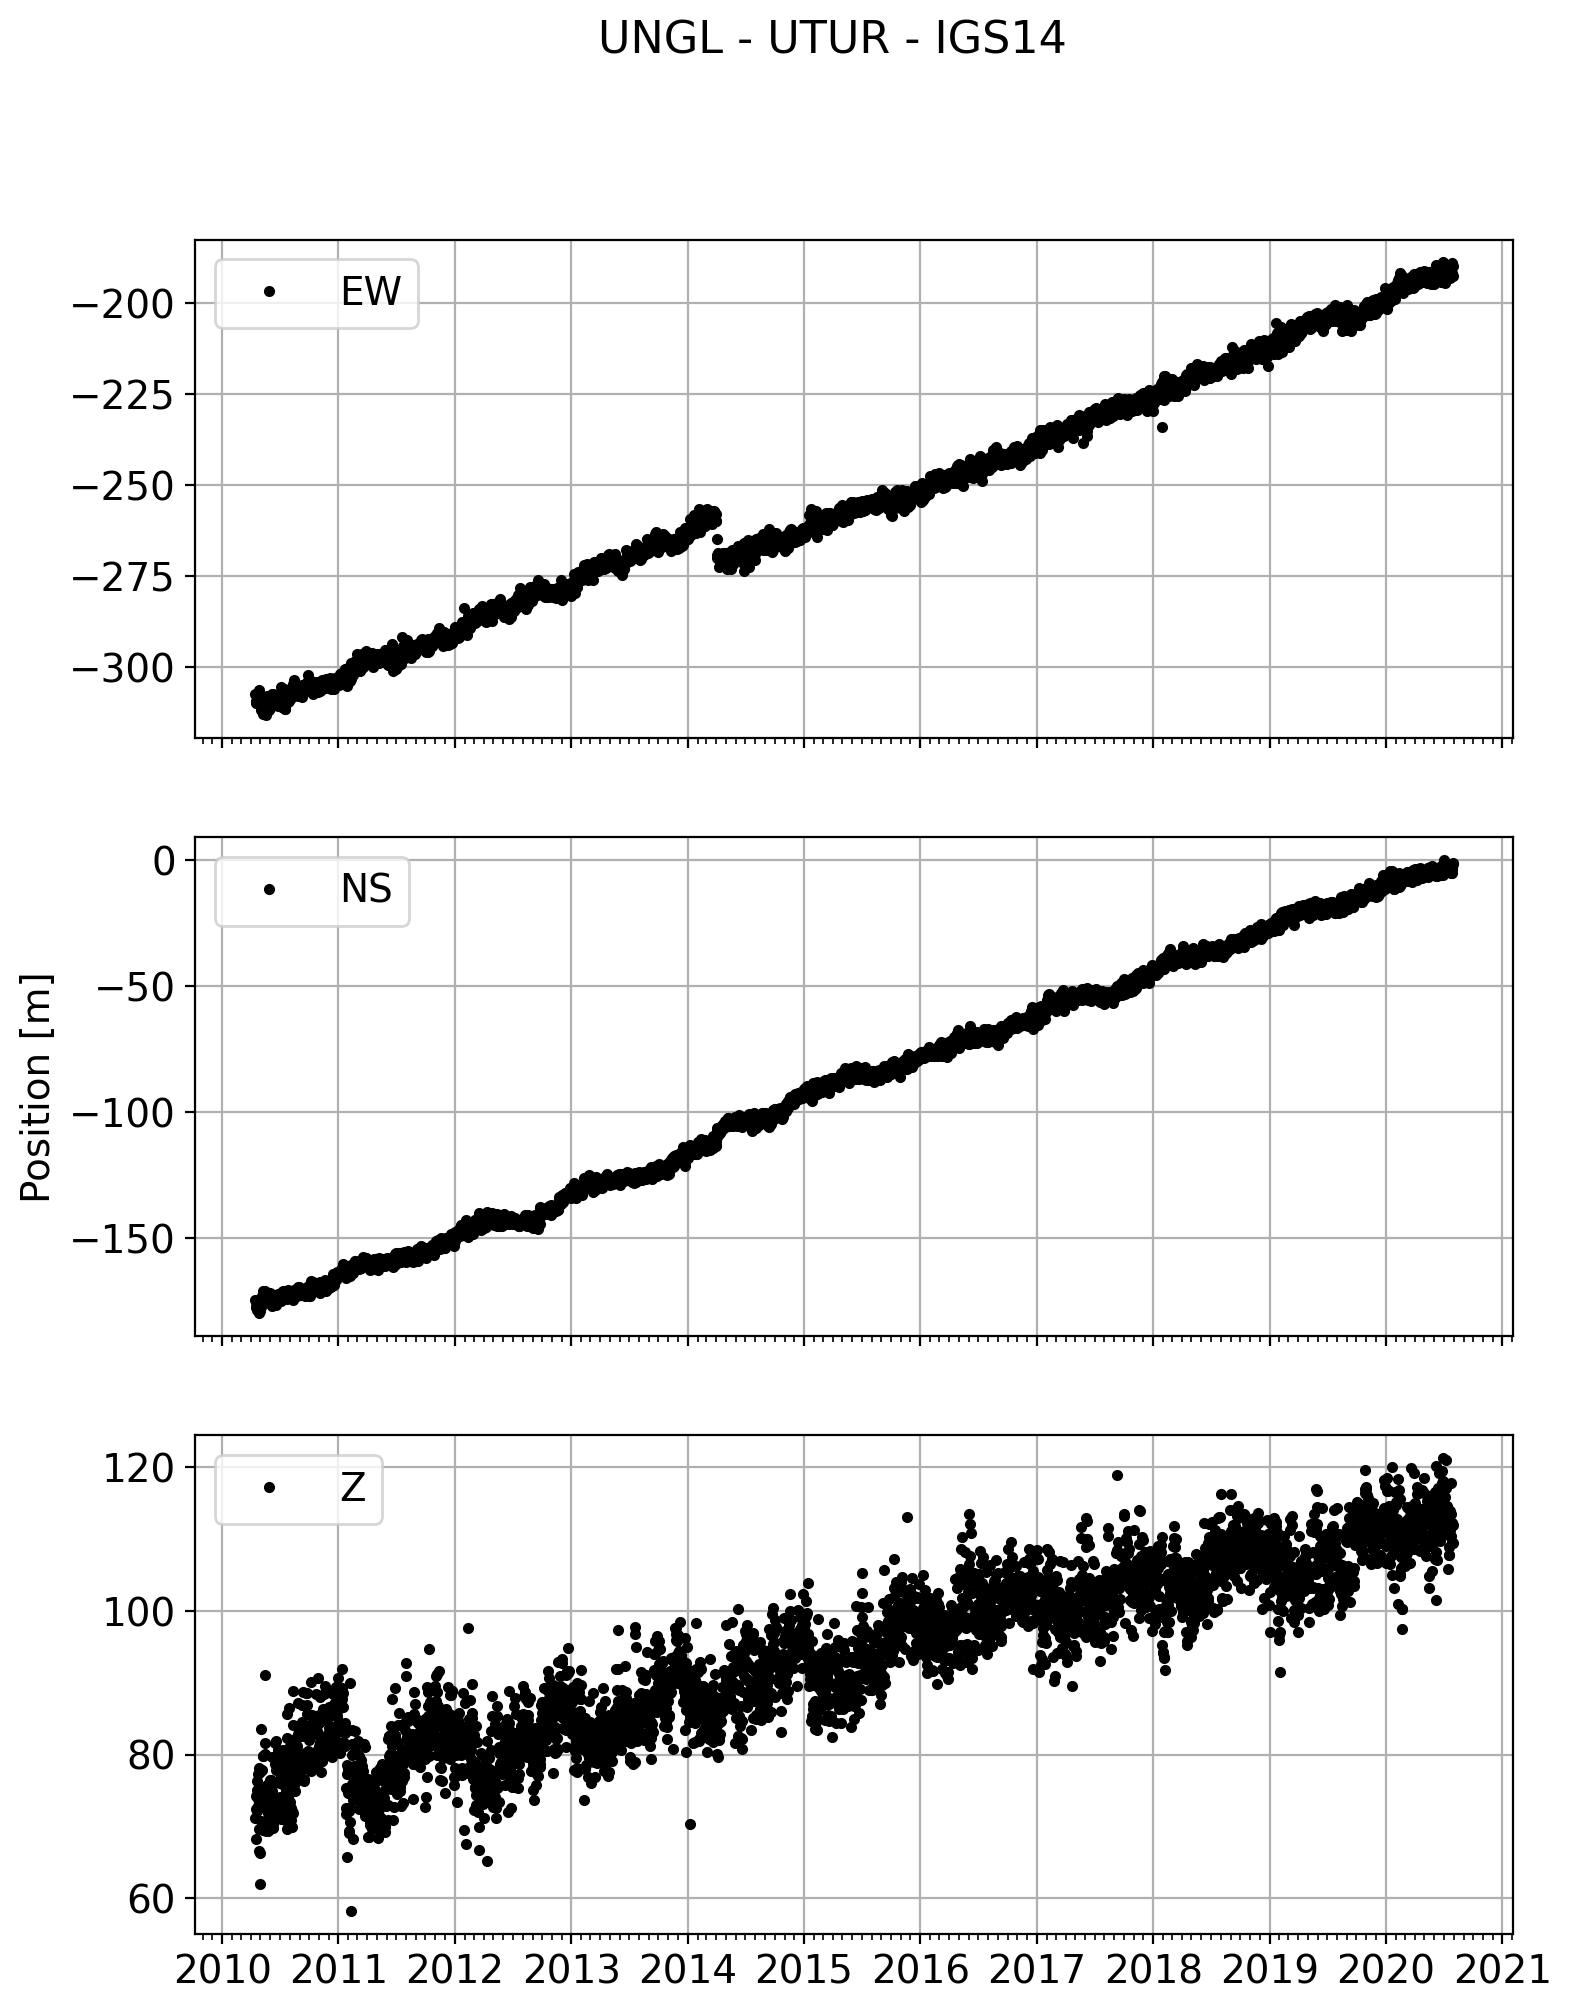

In [7]:
gps.plot.components(df, title=f'UNGL - {station} - {ref}')

# MIDAS automatic linear velocity 

In [8]:
dfM = gps.io.ungl.load_midas(station=site)
dfM

,site,version,start,end,years,epochs,epochs_good,pairs,east,north,...,e0,n0,u0,out_e,out_n,out_u,sig_e,sig_n,sig_u,nsteps
15865,UTUR,MIDAS4,2010.2861,2018.8611,8.575,3128,1856,2141,13.36,16.534,...,-16.885,-0.146,4.489,0.045,0.09,0.067,1.702,1.955,4.424,7


In [9]:
print('East: {:.2f} mm/yr +/- {:.2f} mm/yr'.format(dfM.east.values[0], dfM.err_e.values[0]))
print('North: {:.2f} mm/yr +/- {:.2f} mm/yr'.format(dfM.north.values[0], dfM.err_n.values[0]))
print('Up: {:.2f} mm/yr +/- {:.2f} mm/yr'.format(dfM.up.values[0], dfM.err_u.values[0]))

East: 13.36 mm/yr +/- 0.28 mm/yr
North: 16.53 mm/yr +/- 0.33 mm/yr
Up: 3.57 mm/yr +/- 0.74 mm/yr


# Simple linear regression


In [10]:
# Earthquakes and equipment changes for a particular station
dfCh, dfEq = gps.io.ungl.load_steps(station=site) #equipment changes or earthquakes
dfEq

,site,date,code,thresh_d,distance,mag,id
0,UTUR,2010-07-12,2,223.872,104.579,6.3,usp000hf5z
1,UTUR,2011-06-20,2,251.189,121.389,6.4,usp000j3fk
2,UTUR,2014-04-01,2,1995.262,471.823,8.2,usc000nzvd
3,UTUR,2014-04-03,2,1122.018,387.743,7.7,usc000p27i
4,UTUR,2015-02-11,2,354.813,110.402,6.7,usc000tp1s
5,UTUR,2015-09-16,2,2238.721,1127.860,8.3,us20003k7a
6,UTUR,2017-04-15,2,223.872,125.527,6.3,us10008hu2


In [11]:
# Pisagua Earthquake (https://earthquake.usgs.gov/earthquakes/eventpage/usc000nzvd#executive)
id_eq = 'usc000nzvd'
dfEq.query("id == @id_eq") 

,site,date,code,thresh_d,distance,mag,id
2,UTUR,2014-04-01,2,1995.262,471.823,8.2,usc000nzvd


In [12]:
for comp in ['east','north','up']:
    x = df.decyear
    y = df[comp]
    z,cov = np.polyfit(x, y, 1, cov=True)
    p = np.poly1d(z)
    #print(p)
    print('{}: {:.2f} mm/yr +/- ? mm/yr'.format(comp, p[1]))
    residuals = (p(x) - y)
    rmse = np.sqrt((np.sum(residuals**2) / residuals.size))
    print('rmse = {:.2f}'.format(rmse))
    
#all at once
dfLinear = gps.analysis.fit_linear(df)

east: 11.16 mm/yr +/- ? mm/yr
rmse = 3.78
north: 17.44 mm/yr +/- ? mm/yr
rmse = 2.55
up: 3.67 mm/yr +/- ? mm/yr
rmse = 4.48


# OSU multiparameter fit

In [13]:
# initialize heaviside jump
eq = pd.Timestamp('2014-04-01 23:46:47', tz='UTC')
tj = gps.io.ungl.decyear2date(eq.strftime('%y%b%d').upper(), inverse=True)
tj

2014.2478

In [14]:
# create dataframe for storing results
sites = ['UTUR']
components = ['east','north','up']
iterables = [sites, components]
index = pd.MultiIndex.from_product(iterables, names=['site','comp'])

DF = pd.DataFrame(columns=['t0','xo', 'v', 'b','tj','s1','c1','t1','s2','c2','t2','rmse'], index=index, dtype='f4')

In [15]:
# Test and plot individual station
df = gps.analysis.cull_outliers(df, cols=components) #get rid of really bogus points before fit


for comp in components:
    print('fitting {}...'.format(comp))
    # Fit OSU Model
    t0 = df.decyear[0] # intial time [yr]
    x0 = df[comp][0] # initial position [m]
    v = (df[comp][-1] - df[comp][0]) / (df.decyear[-1] - df.decyear[0])  # trend [m/yr]
    b = 0.0  # step jump offset [m]
    #tj = #see cell above above
    s1 = s2 = c1 = c2 = 0.001 # fourier coefficients [m]
    T1 = 1 # fourier period 1 [yr]
    T2 = 0.5 #fourier period 2 [yr]
    guess = [t0,x0,v,b,tj,s1,c1,s2,c2,T1,T2]

    try:
        guess = [x0,v,b,s1,c1,s2,c2]
        fit,popt,rmse = gps.analysis.invert_osu_knownEQ(df['decyear'], df[comp], tj, guess)
        df.loc[:,'fit_'+comp] = fit
        # add fixed parameters back into popt
        popt = np.insert(popt, [0,3], [t0,tj])
        popt = np.append(popt, [T1,T2])
        DF.loc[(site,comp),:] = np.append(popt,rmse)
    except Exception as e:
        print(e)
        df.loc[:,'fit_'+comp] = gps.analysis.osu(df.decyear.values, *guess) #plot initial guess
        pass


east: Culled 0 points
north: Culled 0 points
up: Culled 1 points
fitting east...
fitting north...
fitting up...


In [17]:
#pd.set_option('precision', 4) # Limit decimal places!
DF.head()

t0          xo          v          b         tj        s1  \
site comp                                                                      
UTUR east   2010.2861 -311.603133  12.944420 -12.972724  2014.2478  0.260095   
     north  2010.2861 -178.171844  16.651576   5.579587  2014.2478 -0.966540   
     up     2010.2861   75.241618   3.433343   1.852371  2014.2478 -0.542335   

                  c1        t1        s2   c2   t2      rmse  
site comp                                                     
UTUR east   0.781245 -0.417735  0.101104  1.0  0.5  1.544936  
     north  1.487538  0.189574 -0.026784  1.0  0.5  1.720551  
     up    -2.531339  0.962036 -0.153900  1.0  0.5  4.000363

In [18]:
print('East: {:.2f} mm/yr +/- ? mm/yr'.format(DF.loc[('UTUR','east'),'v']))
print('North: {:.2f} mm/yr +/- ? mm/yr'.format(DF.loc[('UTUR','north'),'v']))
print('Up: {:.2f} mm/yr +/- ? mm/yr'.format(DF.loc[('UTUR','up'),'v']))

East: 12.94 mm/yr +/- ? mm/yr
North: 16.65 mm/yr +/- ? mm/yr
Up: 3.43 mm/yr +/- ? mm/yr


# Plot several model fits

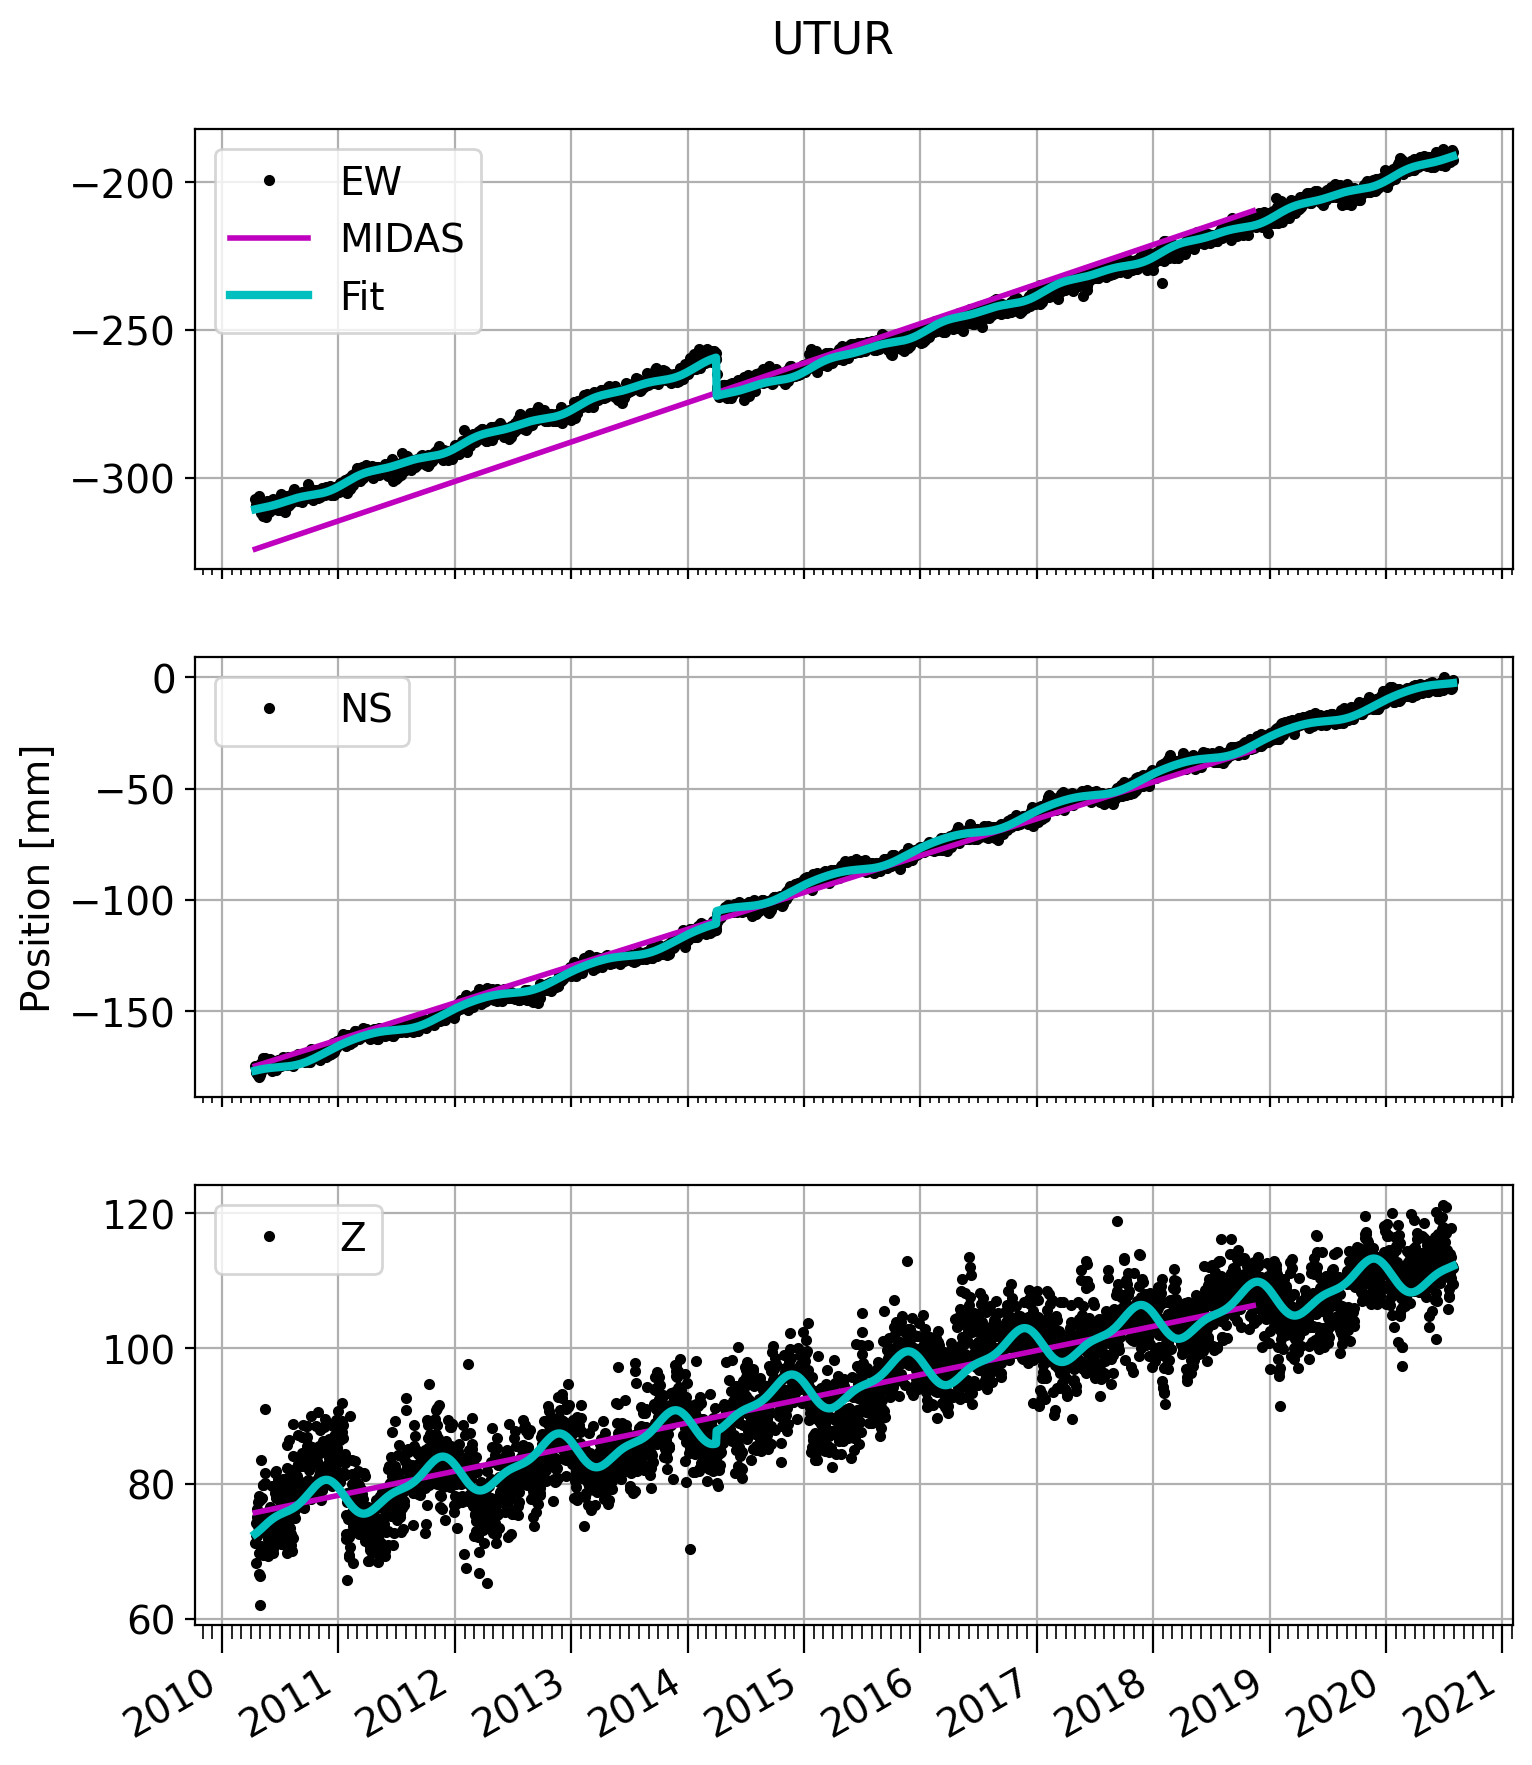

In [19]:
dfLinear = df.loc[:, ['fit_up','fit_north','fit_east']]
dfMidas = gps.io.ungl.add_midas(df, dfM)

gps.plot.all(df, dfSteps=dfEq, dfMidas=dfMidas, dfFit=dfLinear)
plt.suptitle(site, y=0.93, fontsize=16)
plt.savefig('UTUR.pdf', bbox_inches='tight')